# Libraries

In [55]:
# https://www.tensorflow.org/datasets/catalog/malaria
import tensorflow as tf
# array and metrics functionalities
import numpy as np
# image
import cv2
import os
import io
# visualization
import matplotlib.pyplot as plt
# tensorflow dataest loading
import tensorflow_datasets as tfds

import tensorflow_probability as tfp

# model layers
from tensorflow.keras.layers import Normalization, InputLayer, BatchNormalization,Conv2D, MaxPool2D, Dense, Flatten, Resizing, Rescaling, Input, Layer, Dropout

# image augmentation functionalities from layers
from tensorflow.keras.layers import RandomFlip, RandomRotation

# weight optimization
from tensorflow.keras.optimizers import Adam

# loss measurement
from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.models import Model

# measurement metrcics
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC, binary_accuracy

import sklearn
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

# callback functionalities
from tensorflow.keras.callbacks import Callback, CSVLogger, LearningRateScheduler

# regularization
from tensorflow.keras.regularizers import L2

# hyperparameter tuning
from tensorboard.plugins.hparams import api as hp

# wandb
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint,WandbEvalCallback


# Load The Dataset

In [2]:
# https://www.tensorflow.org/datasets/api_docs/python/tfds/load
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.6IJNCN_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


# Split the dataset

In [10]:
def splits(dataset,TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_data = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))# take first 0.8 percnt data
  val_test_data = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE)) # skipping first 0.8 percent data
  val_data = val_test_data.take(int(VAL_RATIO*DATASET_SIZE)) # from the leftover 0.2 data take 0.1
  test_data = val_test_data.skip(int(VAL_RATIO*DATASET_SIZE)) # skipping 0.1 from 0.2 data
  return train_data, val_data, test_data

In [11]:
TRAIN_RATIO = 0.8
VALIDATION_RATIO = 0.1
TEST_RATIO = 0.1
#data = tf.data.Dataset.range(10)
# DATASET_SIZE = len(data)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VALIDATION_RATIO, TEST_RATIO)

In [12]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_SkipDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


# Resize and Reshape

In [13]:
IMG_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255, label

# Batch the data

In [14]:
BATCH_SIZE = 32
# shuffle the data, put into batch, prefetch
train_dataset = (
              train_dataset.
              shuffle(buffer_size = 8, reshuffle_each_iteration = True)
              .map(resize_rescale) # maping after the shuffeling
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE)
              )

val_dataset = (
          val_dataset
          .shuffle(buffer_size = 8,reshuffle_each_iteration=True)
          .map(resize_rescale)# maping after the shuffeling, no image modification here, cause we are validating our model.
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE)
          )

# no need for test dataest
# test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale)

In [15]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


# Weights and Biases [Install, Login, Initialization, Configuration]

https://docs.wandb.ai/guides/integrations/keras/

In [9]:
# !pip install --upgrade wandb

In [9]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: monochandan (monochandan-universit-t-trier) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [11]:
# wandb.init(project="Malaria-Detection", entity = "monochandan-universit-t-trier")
# tensorboard integration: https://docs.wandb.ai/guides/integrations/tensorboard/



### Tensorboard integration in wandb
https://docs.wandb.ai/guides/integrations/tensorboard/

In [12]:
# wandb.tensorboard.patch(root_logdir='./logs/')

In [10]:
wandb.init(project="Malaria-Detection", entity = "monochandan-universit-t-trier", sync_tensorboard=True)

wandb: Currently logged in as: monochandan (monochandan-universit-t-trier) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [11]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 3,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,

}
CONFIGURATION = wandb.config

In [12]:
OPTIMIZER = Adam(learning_rate = 0.01)
EPOCHS = CONFIGURATION['N_EPOCHS']
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()

In [13]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
CUSTOM_TRAIN_DIR = './logs/' + CURRENT_TIME + '/custom/train'
CUSTOM_VAL_DIR = './logs/' + CURRENT_TIME + '/custom/validation'

custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_validation_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


#### Custom Model Training

In [14]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

In [15]:
@tf.function # # graph mode enabled
def training_block(x_batch, y_batch, loss_function):
  with tf.GradientTape() as recorder:
    y_pred = model(x_batch, training = True)
    loss = loss_function(y_batch, y_pred)
  # wandb.log({'loss': loss.numpy()})# easy integration of wandb into tensorboard
  partial_derivative = recorder.gradient(loss, model.trainable_weights) # partial derivative of loss for each and every weights
  OPTIMIZER.apply_gradients(zip(partial_derivative, model.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss

@tf.function # graph mode enabled
def val_block(x_batch_val, y_batch_val, loss_function):
  #for (x_batch_val, y_batch_val) in val_dataset:
  y_pred_val = model(x_batch_val, training = False)
  loss_val = loss_function(y_batch_val, y_pred_val)
  METRIC_VAL.update_state(y_batch_val, y_pred_val)

    # print("Accuracy is for validation:", METRIC_VAL.result)
  # METRIC_VAL.reset_states()
    # print("Loss for validation dataset is {}".format(loss_val))
  return loss_val

In [16]:
def custom_fit(model, loss_function, train_dataset, val_dataset, OPTIMIZER, EPOCHS, METRIC, MATRIC_VAL):

  for epoch in range(EPOCHS):
    print("Training starts for epoch number {}".format(epoch))
    for step, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch, y_batch, loss_function)
    print("Training loss:", loss)
    print("The training accuracy is", METRIC.result())

    # first run Visualization using tensorboard callblock to set the directory -  (METRIC_DIR)
    with custom_train_writer.as_default():
      tf.summary.scalar('Training Loss', data = loss, step = epoch)
    with custom_train_writer.as_default():
      tf.summary.scalar('Training Accuracy', data = METRIC.result(), step = epoch)
    METRIC.reset_state()

    for (x_batch_val, y_batch_val) in val_dataset:
      loss_val = val_block(x_batch_val, y_batch_val, loss_function)

    print("Validation loss: ",loss_val)
    print("Accuracy is for validation:", METRIC_VAL.result())

    # for tensorbord call back
    with custom_validation_writer.as_default():
      tf.summary.scalar('Validation Loss', data = loss_val, step = epoch)
    with custom_train_writer.as_default():
      tf.summary.scalar('Validation Accuracy', data = METRIC_VAL.result(), step = epoch)

    METRIC_VAL.reset_state()
  print("Completed!!!")

In [20]:
# custom_fit(model, custom_bce, train_dataset, val_dataset, OPTIMIZER, EPOCHS, METRIC, METRIC_VAL)

In [21]:
# %load_ext tensorboard

In [22]:
# tensorboard --logdir=logs

## continue wandb

In [23]:
wandb.run

In [17]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 2,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,

}
CONFIGURATION = wandb.config

## Define Model

In [18]:

IMG_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']
POOL_SIZE = CONFIGURATION['POOL_SIZE']

model = tf.keras.Sequential([
  InputLayer(shape= (IMG_SIZE, IMG_SIZE, 3)),
  Conv2D(filters = N_FILTERS, kernel_size = KERNEL_SIZE, strides = N_STRIDES, activation = 'relu', padding = 'same', kernel_regularizer=L2(REGULARIZATION_RATE)),
  BatchNormalization(),
  MaxPool2D(pool_size = POOL_SIZE, strides = N_STRIDES),
  Dropout(DROPOUT_RATE), #

  Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides = N_STRIDES, activation = 'relu', padding = 'same', kernel_regularizer=L2(REGULARIZATION_RATE)),
  BatchNormalization(),
  MaxPool2D(pool_size = POOL_SIZE, strides = N_STRIDES),

  Flatten(),

  Dense(CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
  BatchNormalization(),
  Dropout(DROPOUT_RATE),
  Dense(CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
  BatchNormalization(),
  Dense(1, activation = "sigmoid"),# binary classification



])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 223, 223, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 223, 223, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 223, 223, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 223, 223, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 788544)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    78,854,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,857,097 (300.82 MB)

 Trainable params: 78,856,833 (300.81 MB)

 Non-trainable params: 264 (1.03 KB)

## only charts

In [19]:
class LogImageCallbackWandB(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    predicted = []
    inp = []
    for x, y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    # labels = np.array([i[0] for i in labels ])
    labels = np.array(labels)

    predicted = model.predict(np.array(inp))

    threshold = 0.5 # manualy change the threshold to see the best model, which can reduce FP and increase the TP
    pred = []
    for i in range(len(predicted)):
      if predicted[i] < 0.5:
        pred.append([1,0])
      else:
        pred.append([0,1])

    # pred = np.array(pred)
    #print(pred)
    # cm = confusion_matrix(labels, predicted > threshold) # value > threshold [uninfected]
    # # print(cm)
    # plt.figure(figsize = (8,8))


    # sns.heatmap(cm, annot = True,)
    # plt.title("confusion matrix - {}".format(threshold))
    # plt.ylabel('Actual')
    # plt.xlabel('Predicted')
    # plt.axis('off')

    # buffer = io.BytesIO()
    # plt.savefig(buffer, format = 'png')

    # image_array = tf.image.decode_png(buffer.getvalue(), channels = 3)

    # images = wandb.Image(image_array, caption = "Confusion Matrix for epoch: {}".format(epoch))

    # wandb.log({"Confusion Matrix": images})

    class_names = ['Parasitized', 'Uninfected']
    # np.concatenate([1-predicted, predicted], axis = 1)
    # https://github.com/wandb/wandb/blob/main/wandb/plot/roc_curve.py
    wandb.log({"ROC-CURVE" : wandb.plot.roc_curve(#probs = None,
                                                        y_true = labels,
                                                        y_probas = pred,
                                                       labels = class_names)})
    wandb.log({'loss': logs['loss']}) # log value comes from the metrics, model.compile()

    wandb.log({"Confusion Matrix" : wandb.plot.confusion_matrix(
        probs = pred,
        y_true = labels,
        class_names = class_names)})




## Images

In [20]:
class LogImageCallbackWandBplot(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    predicted = []
    inp = []
    for x, y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    # labels = np.array([i[0] for i in labels ])
    labels = np.array(labels)

    predicted = model.predict(np.array(inp))

    threshold = 0.5 # manualy change the threshold to see the best model, which can reduce FP and increase the TP
    pred = []
    for i in range(len(predicted)):
      if predicted[i] < 0.5:
        pred.append([1,0])
      else:
        pred.append([0,1])

    # pred = np.array(pred)
    #print(pred)
    cm = confusion_matrix(labels, predicted > threshold) # value > threshold [uninfected]
    # print(cm)
    plt.figure(figsize = (8,8))


    sns.heatmap(cm, annot = True,)
    plt.title("confusion matrix - {}".format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format = 'png')

    image_array = tf.image.decode_png(buffer.getvalue(), channels = 3)

    images = wandb.Image(image_array, caption = "Confusion Matrix for epoch: {}".format(epoch))

    wandb.log({"Confusion Matrix": images})




In [21]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [22]:
model.compile(optimizer= Adam(learning_rate =CONFIGURATION['LEARNING_RATE'] ),
              loss = BinaryCrossentropy(),
              metrics = metrics
            )
# LABELS = ['Parasitized', 'Uninfected']

In [30]:
# history = model.fit(train_dataset, validation_data=val_dataset, epochs = 3,verbose = 1,callbacks = [LogImageCallbackWandBplot()])

In [31]:
# wandb.finish()

In [23]:
labels = []
inp = []
predicted = []
for x, y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
      # labels = np.array([i[0] for i in labels ])
      break
# labels = np.array(labels)
predicted = model.predict(np.array(inp))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [24]:
#inp = np.array(inp)
# new_inp = tf.expand_dims(inp, axis = 0)
# print(inp)
print(np.array(inp).shape)
print(np.array(labels).shape)
print(predicted.shape)

(1, 224, 224, 3)
(1,)
(1, 1)


In [26]:
print(predicted.flatten())
print(predicted)

[0.5286246]
[[0.5286246]]


In [28]:
a = tf.constant([[[1,2,3],[4,5,6],[7,6,89]],[[4,2,1],[0,2,5],[1,4,6]]])
print(a.shape)

(2, 3, 3)


In [33]:
print(np.array(a).flatten())

[ 1  2  3  4  5  6  7  6 89  4  2  1  0  2  5  1  4  6]


In [35]:
np.concatenate([1-predicted, predicted], axis = 1).shape

(1, 2)

In [34]:
# np.array(train_dataset.iloc[0])
for x, y in train_dataset.as_numpy_iterator():
  print(x.shape)
  print(y.shape)
  break

(32, 224, 224, 3)
(32,)


In [35]:
test_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [38]:
#

https://docs.wandb.ai/guides/track/log/media/ (log media and objects in wandb)

# Hyperparameter tuning (sweep)

https://docs.wandb.ai/guides/sweeps/walkthrough/

In [36]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 3,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,

}

In [37]:
sweep_configuration = {
    "name": "Maleria-prediction-sweep",
    "method": "random",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        "IM_SIZE": {
        "value" : 224,
    },

    "N_EPOCHS": {
        "value" : 1,
    },

    "KERNEL_SIZE": {
        "value" : 3,
    },

    "N_STRIDES": {
        "value" : 1,
    },

    "POOL_SIZE": {
        "value" : 224,
    },

    "N_FILTERS" : {
        "value" : 6,
    },

    "N_DENSE_1" : {
      "values" : [16, 32, 64, 128]
    },

    "N_DENSE_2" : {
      "values" : [16, 32, 64, 128]
    },

    "DROPOUT_RATE":{
      "min": 0.1,
      "max": 0.4
    },

    "REGULARIZATION_RATE" :{
      "distribution": "uniform",
      "min": 0.001,
      "max": 0.1
    },

    "LEARNING_RATE" :{
      "distribution": "uniform",
      "min": 1e-4,
      "max": 1e-2
    }
    }
}

# HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32,64,128]))
# HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16, 32,64,128]))
# HP_DROPOUT= hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.3]))
# HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001, 0.01, 0.1]))
# HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4,1e-3]))
sweep_id = wandb.sweep(sweep=sweep_configuration)





Create sweep with ID: b2b818ip
Sweep URL: https://wandb.ai/monochandan-universit-t-trier/uncategorized/sweeps/b2b818ip


In [38]:
def model_tuning(config):
  IMG_SIZE = 224
    # droupout_rate = 0.3
    # regularization_rate = 0.01
  model = tf.keras.Sequential([
    InputLayer(shape= (config.IM_SIZE,config.IM_SIZE, 3)),
    Conv2D(filters = config.N_FILTERS, kernel_size = config.KERNEL_SIZE, strides = config.N_STRIDES, activation = 'relu', padding = 'same', kernel_regularizer=L2(config.REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size = config.POOL_SIZE, strides = config.N_STRIDES),
    Dropout(rate = config.DROPOUT_RATE), #

    Conv2D(filters = 16, kernel_size = config.KERNEL_SIZE, strides = config.N_STRIDES, activation = 'relu', padding = 'same', kernel_regularizer=L2(config.REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size = config.POOL_SIZE, strides = config.N_STRIDES),

    Flatten(),

    Dense(config.N_DENSE_1, activation = "relu", kernel_regularizer=L2(config.REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = config.DROPOUT_RATE),
    Dense(config.N_DENSE_2, activation = "relu", kernel_regularizer=L2(config.REGULARIZATION_RATE)),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"),# binary classification



    ])

    # model.summary()

  # model.compile(optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
  #                 loss = BinaryCrossentropy(),
  #                 metrics = ['accuracy']
  #               )
  # model.fit(val_dataset, epochs = 1)
  # _, accuracy = model.evaluate(val_dataset)
  model.summary()
  # return model


In [53]:
# model_tuning(wandb.config)

ValueError: Exception encountered when calling MaxPooling2D.call().

[1mComputed output size would be negative. Received: `inputs.shape=[None 1 1 16]` and `pool_size=[224 224]`.[0m

Arguments received by MaxPooling2D.call():
  • args=('<KerasTensor shape=(None, 1, 1, 16), dtype=float32, sparse=False, name=keras_tensor_21>',)
  • kwargs=<class 'inspect._empty'>

In [ ]:
# def train():
#     with wandb.init(project="Malaria-Detection", entity="monochandan-universit-t-trier", ) as run:
#         config = wandb.config
#         model = model_tuning(config)
#         model.compile(
#               optimizer= Adam(
#                   learning_rate = config.LEARNING_RATE),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'],
#               )
#         model.fit(val_dataset, epochs=config.N_EPOCHS, callbacks = [WandbMetricsLogger()])
#         #wandb.log({"loss": loss, "epoch": epoch})

# count = 5 # number of runs to execute
# wandb.agent(sweep_id, function=train, count=count)


# DataSet Versioning with Weights and Biases


https://docs.wandb.ai/guides/artifacts/construct-an-artifact/

https://docs.wandb.ai/ref/python/sdk/classes/artifact/



In [3]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.S4PMJ0_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [24]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

## numpy zip file for each datafrom dataset

In [50]:
i = 0
for image in dataset[0]:
  # data = {'image': image.numpy()}# , 'label': label.numpy()}
  # print(image[0].shape)
  new_image = tf.image.resize(image[0], (IMG_SIZE, IMG_SIZE))/255
  # print(new_image.shape)
  with open('dataset/malaria_dataset_'+str(i) + '.npz', mode = 'wb') as file:
      np.savez(file, new_image)
      # break
  i += 1
  # after thousend step, print
  if(i%1000 == 0):
    print(i)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [7]:
for data in dataset[0]:
  print(data)
  break

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [ ]:
# with original_data.new_file('original_data.npz', mode = 'wb') as file:
#       np.savez(file, dataset)

In [51]:
def load_original_data():
  with wandb.init(project = "Malaria-Detection", entity = "monochandan-universit-t-trier") as run:
    # created artifacts
    original_data = wandb.Artifact(
      name = 'new_dataset',
      type = 'raw_data',
      description = 'The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.',
      metadata = {"source": "TFDS",
                  "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                  "source_code": "tfds.image_classification.Malaria",
                  "version": "1.0.0",
                  "download_size": "337.08 MiB",
                  },
      # incremental= 'bool',
      # use_as= 'str | None'
    )

    # load the dataset
    # dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

    # save the dataset into numpy compressed format
    # ERROR - InvalidArgumentError: Cannot convert a Tensor of dtype variant to a NumPy array.
    # with original_data.new_file('original_data.npz', mode = 'wb') as file:
    #   np.savez(file, dataset)
    original_data.add_dir("dataset/")
    run.log_artifact(original_data)

In [52]:
load_original_data()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: monochandan (monochandan-universit-t-trier) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (./dataset)... Done. 202.7s


## Layer 2 - Data Preprocessing

In [53]:
run = wandb.init()
artifact = run.use_artifact('monochandan-universit-t-trier/Malaria-Detection/new_dataset:v0', type='raw_data')
artifact_dir = artifact.download() # create an artifact folder

wandb: Downloading large artifact new_dataset:v0, 15831.26MB. 27558 files... 
wandb:   27558 of 27558 files downloaded.  
Done. 0:4:30.0 (58.6MB/s)


In [54]:
print(artifact_dir)

/content/artifacts/new_dataset:v0


In [ ]:
def preprocess_data():
  with wandb.init(project = "Malaria-Detection", entity = "monochandan-universit-t-trier") as run:
    # inlcude the previous artifact to linkup this current preprocessed_data artifact
    artifact = run.use_artifact('monochandan-universit-t-trier/Malaria-Detection/new_dataset:v0', type='raw_data')
    artifact_dir = artifact.download()

    # created artifacts
    preprocessed_data = wandb.Artifact(
      name = 'preprocess_dataset',
      type = 'preprocessed_data',
      description = 'Preprocessed version of malaria dataset',
      # incremental= 'bool',
      # use_as= 'str | None'
    )

    # load the dataset
    # dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

    # save the dataset into numpy compressed format
    # ERROR - InvalidArgumentError: Cannot convert a Tensor of dtype variant to a NumPy array.
    # with original_data.new_file('original_data.npz', mode = 'wb') as file:
    #   np.savez(file, dataset)
    artifact_dir = "/content/artifacts/new_dataset:v0"
    for f in os.listdir(artifact_dir)[:1000]:
      with open(artifact_dir + f, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        x,y = npz_array.f.arr_0

        dataset_x.append(resize_rescale(x))
        dataset_y.append(y)
    # ERROR_1 - can not convert a tensor of dtype variant to a numpy array
    # dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))

    with preprocessed_data.new_file("prep_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y]) # to solve the ERROR_1
    run.log_artifact(preprocessed_data)

In [ ]:
preprocess_data()

In [58]:
print(artifact_dir)

artifacts/new_dataset:v0


In [61]:
artifact_dir = "artifacts/new_dataset:v0/"
for f in os.listdir(artifact_dir):
  with open(artifact_dir + f, 'rb') as file:
    x = np.load(file)
    break

In [66]:
print(type(x))


<class 'numpy.lib.npyio.NpzFile'>


## Layer 3 - Data Spliting

In [ ]:
run = wandb.init()
artifact = run.use_artifact('monochandan-universit-t-trier/Malaria-Detection/new_dataset:v1', type='preprocessed_data')
artifact_dir = artifact.download() # create an artifact folder

In [ ]:
def split_data():
  with wandb.init(project="Malaria-Detection", entity="monochandan-universit-t-trier") as run:

    artifact = run.use_artifact('monochandan-universit-t-trier/Malaria-Detection/preprocessed_data:v2', type='preprocessed_data')
    artifact_dir = artifact.download()

    # train data artifact
    train_data = wandb.Artifact(
        name = "train_dataset",
        type="preprocessed_data",
        description = "Training dataset",

    )
    # validation data artifcat
    val_data = wandb.Artifact(

        name = "val_dataset",
        type="preprocessed_data",
        description = "Validation dataset",

        )
    # test data artifact
    test_data = wandb.Artifact(
        name = "test_dataset",
        type="preprocessed_data",
        description = "Test dataset",

        )

    # file path to access last layer [to get this path first run the above cell]
    artifact_file = "artifacts/preprocessed_dataset:v2/preprocess_dataset.npz"

    # load artifact file
    with open(artifact_file, 'rb') as file:
      npz_arr = np.load(file, allow_pickle = True)
      arr = npz_arr.f.arr_0

    train_split = 0.8
    val_split = 0.1
    test_split = 0.1

    data_len = len(arr[0]) # value of 1000

    # create train array
    # ERROR_1 : slice indicies must be integer or None or have an __index__ method
    # solution ERROR_1 : int() casting
    train_arr = [arr[0][0:int(train_split*data_len)], arr[1][0:int(train_split*data_len)]] # array[0] -> X, array[1] -> Y

    # create validation array
    val_arr = [arr[0][int(train_split*data_len):int((train_split+val_split)*data_len)], arr[1][int(train_split*data_len):int((train_split+val_split)*data_len)] ]

    # create test array
    test_arr = [arr[0][int((train_split+val_split)*data_len):], arr[1][int((train_split+val_split)*data_len):] ]


    with train_data.new_file("train_dataset.npz", mode = "wb") as file:
        np.savez(file, train_arr)

    with val_data.new_file("val_dataset.npz", mode = "wb") as file:
        np.savez(file, val_arr)

    with test_data.new_file("test_dataset.npz", mode = "wb") as file:
        np.savez(file, test_arr)


    run.log_artifact(train_data)
    run.log_artifact(val_data)
    run.log_artifact(test_data)

In [ ]:
split_data()

## Layer 4 - Data Augmentation

In [ ]:
run = wandb.init()
artifact = run.use_artifact('monochandan-universit-t-trier/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
artifact_dir = artifact.download() # create an artifact folder

In [ ]:
def augment(image):
  image = tf.image.rot90(image)
  image = tf.image.flip_left_right(image)

  return image

In [ ]:
def augment_data():
  with wandb.init(project="Malaria-Detection", entity="monochandan-universit-t-trier") as run:

   artifact = run.use_artifact('monochandan-universit-t-trier/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
   artifact_dir = artifact.download()

    augmented_data = wandb.Artifact(
        name = "Augmented_dataset",
        type="preprocessed_data",
        description = "An Augmented version of the Malaria train dataset",
    )

     # file path to access last layer [to get this path first run the above cell]
    artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"

    dataset_x = []
    # open the file
    with open(artifact_file, 'rb') as file:
        # obtain an array
        npz_array = np.load(file, allow_pickle = True)

        arr = npz_array.f.arr_0

        # for every image do the augmentation
        for im in arr[0]:
          dataset_x.append(augment(im))
        dataset_y = arr[1]

    with augmented_data.new_file("aug_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(augmented_data)

In [ ]:
augment_data()

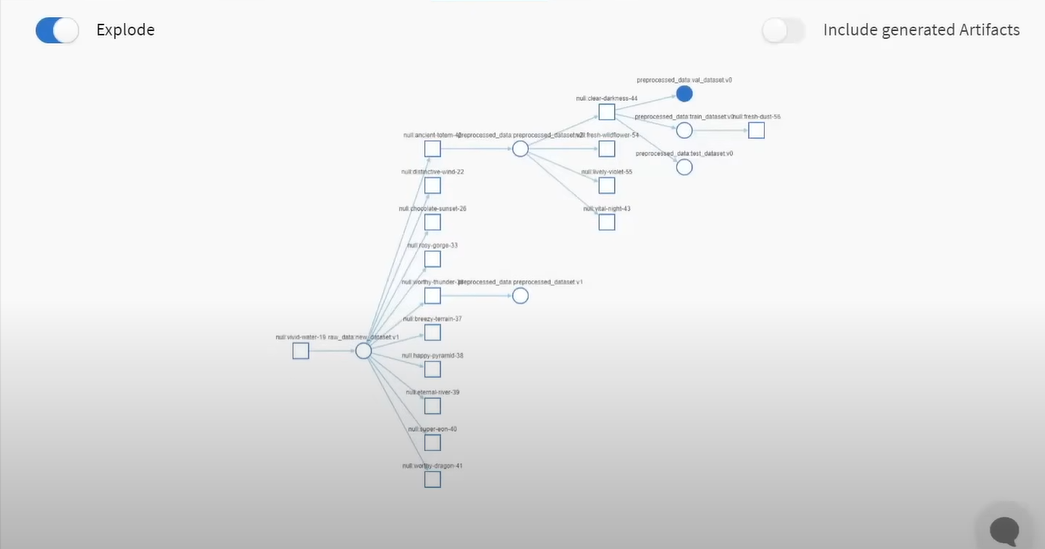